# Deep Learning with PyTorch
---
#### In our previous notebooks, we built neural networks entirely from scratch using just NumPy, gaining a deep understanding of matrix multiplications, forward propagation, backpropagation, and gradient descent.
#### Now, we'll transition to using a powerful deep learning framework: **PyTorch**.
#### **PyTorch** takes care of the heavy lifting for us, from automatic gradient computation to GPU acceleration, allowing us to focus more on building and experimenting, and less on debugging the math. 
#### We'll implement the same deep neural network architecture that we built manually in our previous notebook, first by leveraging PyTorch's low-level tensor operations and automatic differentiation, and then by using its higher-level `nn.Module` API.
---
This notebook assumes you're familiar with the concepts covered in:
- [Logistic Regression from Scratch](https://github.com/vikrawar/from-scratch-logistic-regression)
- [2-Layer NN from Scratch](https://github.com/vikrawar/2-layer-nn-from-scratch)
- [Deep NN from Scratch](https://github.com/vikrawar/deep-nn-from-scratch)

Understanding the manual implementation is key to appreciating the power and abstraction that PyTorch provides!

## Data Generation

We will use the same randomly generated dataset from our previous *[Deep NN from Scratch](https://github.com/vikrawar/deep-nn-from-scratch)* notebook. This dataset has 20 features and 1000 examples with binary labels.

Please note that this is a completly randomly generated dataset with no inherent correlations. This is done to keep the focus on learning.

---

PyTorch tensors are the fundamental data structures in PyTorch. They are akin to NumPy's arrays.

Note on Tensor Shapes: PyTorch expects input data in the format `(batch_size, num_features)`. Therefore, our `X_tensor` will be shaped as `(1000, 20)`, and our `Y_tensor` (for binary classification loss) will be `(1000, 1)`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F # For activation functions
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)

X_tensor = torch.randn(1000, 20).float()
Y_tensor = (torch.rand(1000, 1) > 0.5).float()

print(f"PyTorch X_tensor shape: {X_tensor.shape}")
print(f"PyTorch Y_tensor shape: {Y_tensor.shape}")

PyTorch X_tensor shape: torch.Size([1000, 20])
PyTorch Y_tensor shape: torch.Size([1000, 1])


---

## Building our Neural Network in PyTorch

We will build the same deep neural network architecture `[20, 64, 64, 64, 64, 1]` using PyTorch's fundamental building blocks.

One of the most powerful features of PyTorch is its `autograd` engine. PyTorch automatically computes the gradients for all tensors that have `requires_grad=True`, by calling `.backward()`

### Initializing Parameters

In [2]:
layer_dims = [20, 64, 64, 64, 64, 1]

def initialize_parameters(layer_dims):
    parameters = {}
    for l in range(1, len(layer_dims)):
        # Weights with He initialization (for ReLU)
        parameters[f"W{l}"] = torch.randn(layer_dims[l-1], layer_dims[l]) * torch.sqrt(torch.tensor(2.0 / layer_dims[l-1]))
        parameters[f"W{l}"].requires_grad_(True)
        
        # Biases
        parameters[f"b{l}"] = torch.zeros(1, layer_dims[l])
        parameters[f"b{l}"].requires_grad_(True)
    return parameters

params = initialize_parameters(layer_dims);

print("Initialized parameters:")
for key, value in params.items():
    print(f"{key}: {value.shape}")

Initialized parameters:
W1: torch.Size([20, 64])
b1: torch.Size([1, 64])
W2: torch.Size([64, 64])
b2: torch.Size([1, 64])
W3: torch.Size([64, 64])
b3: torch.Size([1, 64])
W4: torch.Size([64, 64])
b4: torch.Size([1, 64])
W5: torch.Size([64, 1])
b5: torch.Size([1, 1])


### Activation Functions

In [3]:
# ReLU activation
def relu(Z):
    return F.relu(Z)

# Sigmoid activation
def sigmoid(Z):
    return torch.sigmoid(Z)

### Training Loop

In [4]:
def train(X, Y, layer_dims, epochs, lr):

    # Initialize parameters
    params = initialize_parameters(layer_dims)
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    W3, b3 = params['W3'], params['b3']
    W4, b4 = params['W4'], params['b4']
    W5, b5 = params['W5'], params['b5']

    costs = []
    cost = nn.BCELoss() # Binary Cross-Entropy Loss

    print("\n--- Training Deep NN (PyTorch Manual) ---")

    for epoch in range(epochs):
        
        # Forward Pass
        Z1 = X @ W1 + b1 # (1000, 20) @ (20, 64) -> (1000, 64)
        A1 = relu(Z1)
        Z2 = A1 @ W2 + b2 # (1000, 64) @ (64, 64) -> (1000, 64)
        A2 = relu(Z2)
        Z3 = A2 @ W3 + b3 # (1000, 64) @ (64, 64) -> (1000, 64)
        A3 = relu(Z3)
        Z4 = A3 @ W4 + b4 # (1000, 64) @ (64, 64) -> (1000, 64)
        A4 = relu(Z4)
        Z5 = A4 @ W5 + b5 # (1000, 64) @ (64, 1) -> (1000, 1)
        A5 = sigmoid(Z5) # (1000, 1)

        # Backward Pass (Autograd)
        # In PyTorch, each parameter with requires_grad_=True accumulates gradients, as we go throguh the network. 
        # Therefore, we need to zero out the gradients before each backward pass
        W1.grad = None
        b1.grad = None
        W2.grad = None
        b2.grad = None
        W3.grad = None
        b3.grad = None
        W4.grad = None
        b4.grad = None
        W5.grad = None
        b5.grad = None

        # Calculating the cost
        current_cost = cost(A5, Y)
        costs.append(current_cost.item()) # .item() to get scalar value from tensor

        # Calculating the gradients
        current_cost.backward() # Magic happens here!

        # Update Parameters
        with torch.no_grad(): # Disable automatic gradient calculations for the updates
            W1 -= lr * W1.grad
            b1 -= lr * b1.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad
            W3 -= lr * W3.grad
            b3 -= lr * b3.grad
            W4 -= lr * W4.grad
            b4 -= lr * b4.grad
            W5 -= lr * W5.grad
            b5 -= lr * b5.grad

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Cost = {current_cost.item():.4f}")

    # Final prediction and accuracy
    with torch.no_grad(): # Disable automatic gradient calculations for this too
        Z1_final = X @ W1 + b1
        A1_final = relu(Z1_final)
        Z2_final = A1_final @ W2 + b2
        A2_final = relu(Z2_final)
        Z3_final = A2_final @ W3 + b3
        A3_final = relu(Z3_final)
        Z4_final = A3_final @ W4 + b4
        A4_final = relu(Z4_final)
        Z5_final = A4_final @ W5 + b5
        A5_final = sigmoid(Z5_final)
    
    preds = (A5_final > 0.5).float()
    accuracy = (preds == Y).float().mean() 
    print(f"Final Accuracy (PyTorch Manual): {accuracy.item()*100:.2f}%")
    
    return costs

In [5]:
costs_pytorch_low_level = train(X_tensor, Y_tensor, layer_dims, epochs=1001, lr=0.1)


--- Training Deep NN (PyTorch Manual) ---
Epoch 0: Cost = 0.7685
Epoch 100: Cost = 0.5849
Epoch 200: Cost = 0.5007
Epoch 300: Cost = 0.4711
Epoch 400: Cost = 0.1559
Epoch 500: Cost = 0.0806
Epoch 600: Cost = 0.0305
Epoch 700: Cost = 0.0155
Epoch 800: Cost = 0.0094
Epoch 900: Cost = 0.0064
Epoch 1000: Cost = 0.0047
Final Accuracy (PyTorch Manual): 100.00%


## Deep NN with PyTorch's High-Level API (`nn.Module`)

Now, let's see how much cleaner and more abstracted the code becomes when using PyTorch's `nn.Module` and `nn.Linear` layers. 

### Defining the Model Class

This class encapsulates the network's architecture, parameters, and the forward pass logic. It's a much more organized way to define complex models.

In [6]:
class DeepNN(nn.Module):

    # Weights and bias initialization logic
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc4 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc5 = nn.Linear(hidden_dim, output_dim) 

        # Weights with He initialization (for ReLU)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    # Forward pass logic
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x)) 
        x = F.relu(self.fc4(x)) 
        x = torch.sigmoid(self.fc5(x))
        return x

# Instantiate the model
high_level_model = DeepNN(input_dim=layer_dims[0], hidden_dim=layer_dims[1], output_dim=layer_dims[-1])

print("High-Level PyTorch Model Architecture:")
print(high_level_model)

High-Level PyTorch Model Architecture:
DeepNN(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)


### Training Loop

The training loop becomes significantly more concise. We define an `optimizer` to handle parameter updates, and the `.backward()` call on the loss automatically calculates gradients through the `nn.Module`'s computational graph.

In [7]:
def train_deep_nn_pytorch_high_level(model, X, Y, epochs, lr):

    # Loss function
    criterion = nn.BCELoss() 
    
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)

    costs = []
    print("\n--- Training Deep NN (PyTorch High-Level) ---")

    for epoch in range(epochs):
        # Forward Pass
        predictions = model(X)

        # Calculating the cost
        cost = criterion(predictions, Y)
        costs.append(cost.item())

        # Backward Pass and Optimization
        optimizer.zero_grad() # Clear previous gradients
        cost.backward()       # Compute gradients
        optimizer.step()      # Update parameters

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {cost.item():.4f}")

    # Final prediction and accuracy
    with torch.no_grad(): # Disable automatic gradient calculations for evaluation
        final_predictions = model(X)
    
    preds_binary = (final_predictions > 0.5).float()
    accuracy = (preds_binary == Y).float().mean()
    print(f"Final Accuracy (PyTorch High-Level): {accuracy.item()*100:.2f}%")
    
    return costs

In [8]:
costs_pytorch_high_level = train_deep_nn_pytorch_high_level(high_level_model, X_tensor, Y_tensor, epochs=1001, lr=0.1)


--- Training Deep NN (PyTorch High-Level) ---
Epoch 0: Loss = 0.7338
Epoch 100: Loss = 0.5865
Epoch 200: Loss = 0.4866
Epoch 300: Loss = 0.3612
Epoch 400: Loss = 0.1917
Epoch 500: Loss = 1.8863
Epoch 600: Loss = 0.0331
Epoch 700: Loss = 0.0173
Epoch 800: Loss = 0.0108
Epoch 900: Loss = 0.0074
Epoch 1000: Loss = 0.0055
Final Accuracy (PyTorch High-Level): 100.00%


## Plotting the Cost

Let's compare the training costs of the manual PyTorch implementation and the high-level `nn.Module` implementation. Ideally, they should show very similar learning curves, demonstrating that the higher-level API effectively abstracts away the underlying manual tensor operations.

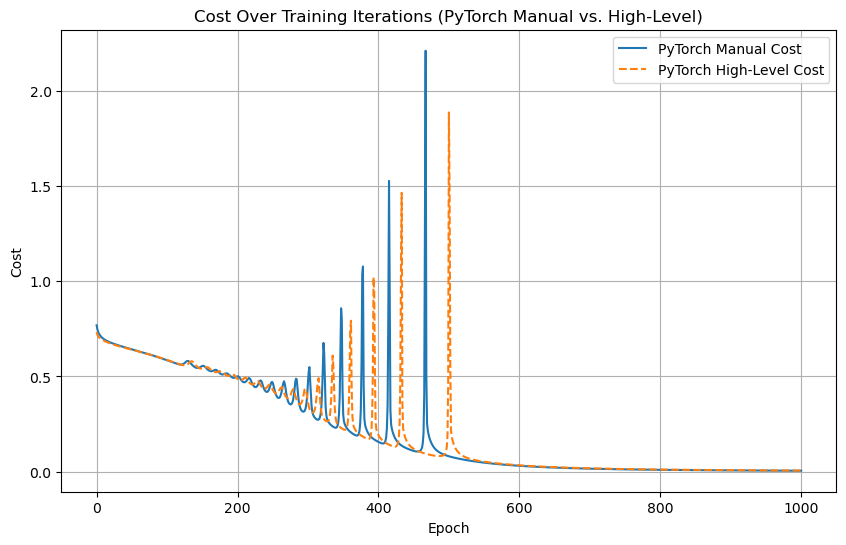

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(costs_pytorch_low_level, label='PyTorch Manual Cost')
plt.plot(costs_pytorch_high_level, label='PyTorch High-Level Cost', linestyle='--')
plt.title('Cost Over Training Iterations (PyTorch Manual vs. High-Level)')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

Note how the cost reduces at a much faster pace as compaired with our manual NumPy implementation. PyTorch has many such under the hood optimizations.  
Again, don't worry about the cost bouncing up and down in the middle, such is the nature of neural networks (specially as we go deeper and deeper). Techniques have been created to counter this behavior, which I hope to get into in future notebooks!

---

## 🎉 Wrap-Up

In this notebook, we took our manually built deep neural network and recreated it using PyTorch:

-   We started with a **low-level PyTorch implementation**, using `torch.Tensor` operations and managing gradients via `autograd`. This showed how our NumPy from scratch implementation maps to PyTorch.
-   We then transitioned to a **high-level PyTorch implementation** using `nn.Module` and `nn.Linear`. This showcased the abstraction and efficiency that PyTorch provides for building and training complex models.

Both approaches yielded comparable results, demonstrating that PyTorch's higher-level APIs simply streamline the process without sacrificing control or functionality.  
I hope this journey, from building neural networks from scratch uning NumPy, to building neural networks using a powerful high level library, PyTorch, has equipped you with a deeper understanding of deep learning and what happens under the hood of neural networks and 

---

Thanks for following along!  
If you found this helpful, consider ⭐️ the repo or sharing it with someone learning deep learning.